# Model Prep, Selection, Tuning and Conclusion

In this notebook, with the preprocessed data, I will apply a few models and select the best parameters to train the data. 

Contents:
- [Imports](#Import-libraries-and-data)
- [Model Prep](#Model-preparation)
- [Model Selection](#Model-selection)
- [Model Hyperparameter Tuning and Evaluation](#Model-hyperparameter-tuning-and-evaluation)
- [Conclusion](#Conclusion)

### Import libraries and data

In [100]:
# import libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from prettytable import PrettyTable
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [101]:
# import data
titles_lemm = pd.read_csv("../data/titles_lemm.csv")
titles_stemm = pd.read_csv("../data/titles_stemm.csv")
comments_lemm = pd.read_csv("../data/comments_lemm.csv")
comments_stemm = pd.read_csv("../data/comments_stemm.csv")
#check
titles_lemm.head()

,titles,subreddit
0,twitter s ban on trump strips us of moral high...,1
1,parler finds refuge with right leaning webhost...,1
2,sorry cleveland,1
3,elon musk a lot of people are going to be supe...,1
4,democrat law professor trump never actually ca...,1


### Model preparation

Split data into X (text feature) and y (target).

In [102]:
Xtl = titles_lemm['titles'].astype('U').values# pandas series cos countvectorizer requires a vector
ytl = titles_lemm['subreddit'].astype('U').values

Xts = titles_stemm['titles'].astype('U').values # pandas series cos countvectorizer requires a vector
yts = titles_stemm['subreddit'].astype('U').values

Xcl = comments_lemm['comments'].astype('U').values # pandas series cos countvectorizer requires a vector
ycl = comments_lemm['subreddit'].astype('U').values

Xcs = comments_stemm['comments'].astype('U').values # pandas series cos countvectorizer requires a vector
ycs = comments_stemm['subreddit'].astype('U').values

As there is an imbalanced class, I apply random oversampling, using RandomOverSampler (ROS) to balance the class. With random oversampling, randomly selected samples from the minority class will be appended, with replacement, to the original dataset (Imbalanced-learn, 2017).

In [103]:
#instantiate
ros = RandomOverSampler(sampling_strategy = 'minority')
#fit
Xtl_ros, ytl_ros = ros.fit_resample(Xtl.reshape(-1,1),ytl) 
Xts_ros, yts_ros = ros.fit_resample(Xts.reshape(-1,1),yts)
Xcl_ros, ycl_ros = ros.fit_resample(Xcl.reshape(-1,1),ycl)
Xcs_ros, ycs_ros = ros.fit_resample(Xcs.reshape(-1,1),ycs)

In [104]:
#change to array suitable to fit
Xtl_ros = Xtl_ros.ravel()
Xts_ros = Xts_ros.ravel()
Xcl_ros = Xcl_ros.ravel()
Xcs_ros = Xcs_ros.ravel()

Split data into training and test sets, then split the training set into training and validation sets.

In [105]:
# split into train and testing set
Xtl_train, Xtl_test, ytl_train, ytl_test = train_test_split(Xtl_ros, ytl_ros, random_state = 42)
Xts_train, Xts_test, yts_train, yts_test = train_test_split(Xts_ros, yts_ros, random_state = 42)
Xcl_train, Xcl_test, ycl_train, ycl_test = train_test_split(Xcl_ros, ycl_ros, random_state = 42)
Xcs_train, Xcs_test, ycs_train, ycs_test = train_test_split(Xcs_ros, ycs_ros, random_state = 42)

# split train set into train and validation set
Xtl_train, Xtl_val, ytl_train, ytl_val = train_test_split(Xtl_train, ytl_train, random_state = 42)
Xts_train, Xts_val, yts_train, yts_val = train_test_split(Xts_train, yts_train, random_state = 42)
Xcl_train, Xcl_val, ycl_train, ycl_val = train_test_split(Xcl_train, ycl_train, random_state = 42)
Xcs_train, Xcs_val, ycs_train, ycs_val = train_test_split(Xcs_train, ycs_train, random_state = 42)

### Model selection

I first fit data into a few pipeline models, without changing the parameters. This will be the baseline model from which I will then score and select the best performing model to go forward with. In evaluating the models, there a few metrics considered below (Vidhya, 2020) : 

| Metric | Elaboration and Analysis |
| :-----: | :-------- | 
| Accuracy | provides fraction of predictions that the model got right (ie. number of correct predictions / total number of predictions). This metric may not work well on imbalanced classes like the data I collected, but since I have balanced the classes with `RandomOverSampling`, I can rely on the accuracy metric.  |
| Precision | provides the fraction of correctly identified positives out of all predicted positives. [TP / (TP + FP)]. This indicates how much we can trust the algorithm when it predicts a class. |
| Recall/Sensitivity | provides the fraction of correctly identified as positive out of all positives. [TP / (TP + FN)] . This shows how many of the true labels of the class is predicted correctly. |
| F1-score | a harmonic mean of precision and recall. While we want to maximise precision and recall, it is a trade-off. Since I have no bias towards any classes (ie. predicting a post to be from `r/Conservative` is as good/bad as predicting a post to be from `r/democrats`), the F1 score may not as important as accuracy, foy this project. |

Once selected the best performing model, I will then tune the hyperparameters.

In [106]:
#pipelines
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('dt', DecisionTreeClassifier())
])

pipe4 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('sv', SVC())
])

#params
pipe1_params = {}
pipe2_params = {}
pipe3_params = {}
pipe4_params = {}
pipe5_params = {}

In [107]:
# load pipe into gridsearch but without param changes, using f1 as the scoring method
gs1 = GridSearchCV(pipe1, param_grid = pipe1_params, cv = 5)
gs2 = GridSearchCV(pipe2, param_grid = pipe2_params, cv = 5)
gs3 = GridSearchCV(pipe3, param_grid = pipe3_params, cv = 5)
gs4 = GridSearchCV(pipe4, param_grid = pipe4_params, cv = 5)
gs5 = GridSearchCV(pipe5, param_grid = pipe5_params, cv = 5)

# fit model on first pipe
gs1.fit(Xtl_train,ytl_train)
gs1_tl_score = round(gs1.best_score_,3)
gs1_tl_train_score = round(gs1.score(Xtl_train,ytl_train),3)
gs1_tl_val_score = round(gs1.score(Xtl_val,ytl_val),3)

gs1.fit(Xts_train,yts_train)
gs1_ts_score = round(gs1.best_score_,3)
gs1_ts_train_score = round(gs1.score(Xts_train,yts_train),3)
gs1_ts_val_score = round(gs1.score(Xts_val,yts_val),3)

gs1.fit(Xcl_train,ycl_train)
gs1_cl_score = round(gs1.best_score_,3)
gs1_cl_train_score = round(gs1.score(Xcl_train,ycl_train),3)
gs1_cl_val_score = round(gs1.score(Xcl_val,ycl_val),3)

gs1.fit(Xcs_train,ycs_train)
gs1_cs_score = round(gs1.best_score_,3)
gs1_cs_train_score = round(gs1.score(Xcs_train,ycs_train),3)
gs1_cs_val_score = round(gs1.score(Xcs_val,ycs_val),3)

# fit model on second pipe
gs2.fit(Xtl_train,ytl_train)
gs2_tl_score = round(gs2.best_score_,3)
gs2_tl_train_score = round(gs2.score(Xtl_train,ytl_train),3)
gs2_tl_val_score = round(gs2.score(Xtl_val,ytl_val),3)

gs2.fit(Xts_train,yts_train)
gs2_ts_score = round(gs2.best_score_,3)
gs2_ts_train_score = round(gs2.score(Xts_train,yts_train),3)
gs2_ts_val_score = round(gs2.score(Xts_val,yts_val),3)

gs2.fit(Xcl_train,ycl_train)
gs2_cl_score = round(gs2.best_score_,3)
gs2_cl_train_score = round(gs2.score(Xcl_train,ycl_train),3)
gs2_cl_val_score = round(gs2.score(Xcl_val,ycl_val),3)

gs2.fit(Xcs_train,ycs_train)
gs2_cs_score = round(gs2.best_score_,3)
gs2_cs_train_score = round(gs2.score(Xcs_train,ycs_train),3)
gs2_cs_val_score = round(gs2.score(Xcs_val,ycs_val),3)

# fit model on third pipe
gs3.fit(Xtl_train,ytl_train)
gs3_tl_score = round(gs3.best_score_,3)
gs3_tl_train_score = round(gs3.score(Xtl_train,ytl_train),3)
gs3_tl_val_score = round(gs3.score(Xtl_val,ytl_val),3)

gs3.fit(Xts_train,yts_train)
gs3_ts_score = round(gs3.best_score_,3)
gs3_ts_train_score = round(gs3.score(Xts_train,yts_train),3)
gs3_ts_val_score = round(gs3.score(Xts_val,yts_val),3)

gs3.fit(Xcl_train,ycl_train)
gs3_cl_score = round(gs3.best_score_,3)
gs3_cl_train_score = round(gs3.score(Xcl_train,ycl_train),3)
gs3_cl_val_score = round(gs3.score(Xcl_val,ycl_val),3)

gs3.fit(Xcs_train,ycs_train)
gs3_cs_score = round(gs3.best_score_,3)
gs3_cs_train_score = round(gs3.score(Xcs_train,ycs_train),3)
gs3_cs_val_score = round(gs3.score(Xcs_val,ycs_val),3)

# fit model on fourth pipe
gs4.fit(Xtl_train,ytl_train)
gs4_tl_score = round(gs4.best_score_,3)
gs4_tl_train_score = round(gs4.score(Xtl_train,ytl_train),3)
gs4_tl_val_score = round(gs4.score(Xtl_val,ytl_val),3)

gs4.fit(Xts_train,yts_train)
gs4_ts_score = round(gs4.best_score_,3)
gs4_ts_train_score = round(gs4.score(Xts_train,yts_train),3)
gs4_ts_val_score = round(gs4.score(Xts_val,yts_val),3)

gs4.fit(Xcl_train,ycl_train)
gs4_cl_score = round(gs4.best_score_,3)
gs4_cl_train_score = round(gs4.score(Xcl_train,ycl_train),3)
gs4_cl_val_score = round(gs4.score(Xcl_val,ycl_val),3)

gs4.fit(Xcs_train,ycs_train)
gs4_cs_score = round(gs4.best_score_,3)
gs4_cs_train_score = round(gs4.score(Xcs_train,ycs_train),3)
gs4_cs_val_score = round(gs4.score(Xcs_val,ycs_val),3)

# fit model on fourth pipe
gs5.fit(Xtl_train,ytl_train)
gs5_tl_score = round(gs5.best_score_,3)
gs5_tl_train_score = round(gs5.score(Xtl_train,ytl_train),3)
gs5_tl_val_score = round(gs5.score(Xtl_val,ytl_val),3)

gs5.fit(Xts_train,yts_train)
gs5_ts_score = round(gs5.best_score_,3)
gs5_ts_train_score = round(gs5.score(Xts_train,yts_train),3)
gs5_ts_val_score = round(gs5.score(Xts_val,yts_val),3)

gs5.fit(Xcl_train,ycl_train)
gs5_cl_score = round(gs5.best_score_,3)
gs5_cl_train_score = round(gs5.score(Xcl_train,ycl_train),3)
gs5_cl_val_score = round(gs5.score(Xcl_val,ycl_val),3)

gs5.fit(Xcs_train,ycs_train)
gs5_cs_score = round(gs5.best_score_,3)
gs5_cs_train_score = round(gs5.score(Xcs_train,ycs_train),3)
gs5_cs_val_score = round(gs5.score(Xcs_val,ycs_val),3)

In [108]:
# view results in table 
x = PrettyTable(title = "Results of Pipeline 1 (Count Vectorizer, Logistic Regression)", header_style = 'title', max_table_width = 120)
x.field_names = [" ", "titles_lemm", "titles_stemm", "comments_lemm", "comments_stemm"]
x.add_row(["Best accuracy score across folds", gs1_tl_score, gs1_ts_score , gs1_cl_score, gs1_cs_score])
x.add_row(["Accuracy score on Train Set", gs1_tl_train_score, gs1_ts_train_score, gs1_cl_train_score, gs1_cs_train_score])
x.add_row(["Accuracy score on Validation Set", gs1_tl_val_score, gs1_ts_val_score, gs1_cl_val_score, gs1_cs_val_score])
print(x)

y = PrettyTable(title = "Results of Pipeline 2 (Tf-idf Vectorizer, Multinomial Naive Bayes)", header_style = 'title', max_table_width = 120)
y.field_names = [" ", "titles_lemm", "titles_stemm", "comments_lemm", "comments_stemm"]
y.add_row(["Best accuracy score across folds", gs2_tl_score, gs2_ts_score , gs2_cl_score, gs2_cs_score])
y.add_row(["Accuracy score on Train Set", gs2_tl_train_score, gs2_ts_train_score, gs2_cl_train_score, gs2_cs_train_score])
y.add_row(["Accuracy score on Validation Set", gs2_tl_val_score, gs2_ts_val_score, gs2_cl_val_score, gs2_cs_val_score])
print(y)

z = PrettyTable(title = "Results of Pipeline 3 (Count Vectorizer, Decision Tree Classifier)", header_style = 'title', max_table_width = 120)
z.field_names = [" ", "titles_lemm", "titles_stemm", "comments_lemm", "comments_stemm"]
z.add_row(["Best accuracy score across folds", gs3_tl_score, gs3_ts_score , gs3_cl_score, gs3_cs_score])
z.add_row(["Accuracy score on Train Set", gs3_tl_train_score, gs3_ts_train_score, gs3_cl_train_score, gs3_cs_train_score])
z.add_row(["Accuracy score on Validation Set", gs3_tl_val_score, gs3_ts_val_score, gs3_cl_val_score, gs3_cs_val_score])
print(z)

a = PrettyTable(title = "Results of Pipeline 4 (Count Vectorizer, Random Forest Classifier)", header_style = 'title', max_table_width = 120)
a.field_names = [" ", "titles_lemm", "titles_stemm", "comments_lemm", "comments_stemm"]
a.add_row(["Best accuracy score across folds", gs4_tl_score, gs4_ts_score , gs4_cl_score, gs4_cs_score])
a.add_row(["Accuracy score on Train Set", gs4_tl_train_score, gs4_ts_train_score, gs4_cl_train_score, gs4_cs_train_score])
a.add_row(["Accuracy score on Validation Set", gs4_tl_val_score, gs4_ts_val_score, gs4_cl_val_score, gs4_cs_val_score])
print(a)

b = PrettyTable(title = "Results of Pipeline 5 (Count Vectorizer, Support Vector Classifier)", header_style = 'title', max_table_width = 120)
b.field_names = [" ", "titles_lemm", "titles_stemm", "comments_lemm", "comments_stemm"]
b.add_row(["Best accuracy score across folds", gs5_tl_score, gs5_ts_score , gs5_cl_score, gs5_cs_score])
b.add_row(["Accuracy score on Train Set", gs5_tl_train_score, gs5_ts_train_score, gs5_cl_train_score, gs5_cs_train_score])
b.add_row(["Accuracy score on Validation Set", gs5_tl_val_score, gs5_ts_val_score, gs5_cl_val_score, gs5_cs_val_score])
print(b)

+------------------------------------------------------------------------------------------------+
|                 Results of Pipeline 1 (Count Vectorizer, Logistic Regression)                  |
+----------------------------------+-------------+--------------+---------------+----------------+
|                                  | Titles_Lemm | Titles_Stemm | Comments_Lemm | Comments_Stemm |
+----------------------------------+-------------+--------------+---------------+----------------+
| Best accuracy score across folds |    0.814    |    0.814     |     0.914     |     0.913      |
|   Accuracy score on Train Set    |    0.994    |    0.996     |     0.983     |     0.985      |
| Accuracy score on Validation Set |    0.786    |    0.821     |     0.931     |     0.932      |
+----------------------------------+-------------+--------------+---------------+----------------+
+------------------------------------------------------------------------------------------------+
|         

From the above results, I note the following :

1. Comments always have a better score than titles, so I willl use the comments data to train in the final model. This is expected since there is more data available in comments than titles (ie. there can be several hundreds of comments on a particular post)  


2. Generally, stemmed words have a better score than lemmatized words. This is likely because words used in both `r/Conservative` and `r/democrats` are already very distinct from each other, such that a harsher truncation by stemming makes the model more effective. 


3. Comparing scores on train set, the `RandomForestClassifier` and the `DecisionTreeClassifier` were the best performing model. However, when looking at the average `cross_val_score`, the `RandomForestClassifier` did better. 


Based on this analysis, I will move forward with the `RandomForestClassifier` model (ie. Pipeline 4)

### Model hyperparameter tuning and evaluation
I now tune the hyperparameters of the pipeline so it can perform better.

In [109]:
%%time
# insert parameters to search over
pipe4_params = {
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [2, 3, 6], # limits vocab size by requiring a term appearing in x number of documents to be considered as part of the vocabulary
    'rf__max_depth': [None, 1, 3]
}
# load pipe into grid search
gs = GridSearchCV(pipe4, param_grid = pipe4_params, cv = 5)

# fit model
gs.fit(Xcs_train, ycs_train)

# view best score
print(f'The best accuracy score is : {gs.best_score_}')
print(f'The best parameters are : {gs.best_params_}')

#view results in a table
c = PrettyTable(title = "Best Score and Parameters on Training and Test Set ", header_style = 'title', max_table_width = 110)
c.field_names = ["Dataset", "Accuracy Score"]
c.add_row(["Training Set ", round(gs.score(Xcs_train,ycs_train),3)])
c.add_row(["Validation Set", round(gs.score(Xcs_val,ycs_val),3)])
c.add_row(["Test Set", round(gs.score(Xcs_test,ycs_test),3)])
print(c)

The best accuracy score is : 0.9740546342745734
The best parameters are : {'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'rf__max_depth': None}
+---------------------------------------------------+
| Best Score and Parameters on Training and Test Set  |
+-------------------------+-------------------------+
|         Dataset         |      Accuracy Score     |
+-------------------------+-------------------------+
|      Training Set       |          0.994          |
|      Validation Set     |          0.985          |
|         Test Set        |          0.979          |
+-------------------------+-------------------------+
Wall time: 1min 53s


From tuning of the hyperparameters, the model performed better than the baseline. Looking at the best parameters,I note the following:

1. Surprisingly, not removing stop words improved the model. This suggests that stop words help in making sense of the data with respect to each subreddit. 


2. ngram range is (1,2) which means both unigrams and bigrams (ie. single words or two words back-to-back) are considered together in training the model to help it perform better. 

Comparing results to the test set, there is only a small overfit.

In [110]:
%%time
# insert best parameters
pipex_params = {
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': [None],
    'cvec__min_df': [2], # limits vocab size by requiring a term appearing in x number of documents to be considered as part of the vocabulary
    'rf__max_depth': [None]
}
# load pipe into grid search
gsx = GridSearchCV(pipe4, param_grid = pipex_params, cv = 5)

# fit model
gsx.fit(Xcs_train, ycs_train)

# view best score
print(f'The best accuracy score is : {gsx.best_score_}')

#view results in a table
d = PrettyTable(title = "Accuracy Score with Best Parameters on Training, Validation and Test Set ", header_style = 'title', max_table_width = 110)
d.field_names = ["Dataset", "Accuracy Score"]
d.add_row(["Accuracy score on Training Set ", round(gsx.score(Xcs_train,ycs_train),3)])
d.add_row(["Accuracy score on Validation Set", round(gsx.score(Xcs_val,ycs_val),3)])
d.add_row(["Accuracy score on Test Set", round(gsx.score(Xcs_test,ycs_test),3)])
print(d)

The best accuracy score is : 0.9736360051698834
+--------------------------------------------------------------------------+
| Accuracy Score with Best Parameters on Training, Validation and Test Set  |
+--------------------------------------------------+-----------------------+
|                     Dataset                      |     Accuracy Score    |
+--------------------------------------------------+-----------------------+
|         Accuracy score on Training Set           |         0.994         |
|         Accuracy score on Validation Set         |         0.985         |
|            Accuracy score on Test Set            |         0.979         |
+--------------------------------------------------+-----------------------+
Wall time: 13.8 s


In [111]:
y_pred = gsx.predict(Xcs_test)
y_pred = [int(numeric_list) for numeric_list in y_pred]
ycs_test = [int(numeric_list) for numeric_list in ycs_test]
# y_probs = gs.predict_proba(Xcs_test)
accuracy_score = round(accuracy_score(ycs_test, y_pred),3)
precision_score = round(precision_score(ycs_test, y_pred),3)
recall_score = round(recall_score(ycs_test, y_pred),3)
f1_score = round(f1_score(ycs_test, y_pred),3)

In [112]:
# view results in table
e = PrettyTable(title = "Overview of Scores", header_style = 'title', max_table_width = 120)
e.field_names = ["Dataset", "Accuracy Score", "Precision Score", "Recall Score", "F1 Score"]
e.add_row(["Test Set", accuracy_score, precision_score, recall_score, f1_score])
print(e)

+-----------------------------------------------------------------------+
|                           Overview of Scores                          |
+----------+----------------+-----------------+--------------+----------+
| Dataset  | Accuracy Score | Precision Score | Recall Score | F1 Score |
+----------+----------------+-----------------+--------------+----------+
| Test Set |     0.979      |      0.969      |     0.99     |  0.979   |
+----------+----------------+-----------------+--------------+----------+


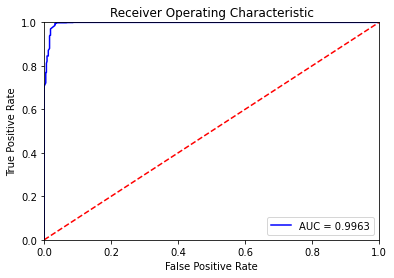

In [114]:
# calculate the fpr and tpr for all thresholds of the classification
probs = gs.predict_proba(Xcs_test)
preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(ycs_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

From the ROC AUC curve, with a well-performing model, we see that the AUC is close to one.

### Conclusion

Random Forest Classifier performed really well to classify a post between `r/Conservative` and `r/democrats`. This is expected as from the data exploration done earlier, we see pretty distinct words used in each of these subreddits. While we would expect similar topics to be discussed or similar mentions in both `r/Conservative` and  `r/democrats`, from our results, it appears that the content that is discussed in each subreddit goes in very different directions (ie. redditors use very distinct words for each subreddit).

**Further Development**

With this model, we can perform further sentiment analysis and from public sentiment, we could predict outcomes of future elections. Businesses would then be able to prepare for policy changes and if needed pivot the business in favour of any upcoming policy changes. 

## References

"Over-sampling" (Imbalanced-learn, 2017)
https://imbalanced-learn.org/stable/over_sampling.html#random-over-sampler

"CountVectorizer in Python" (Educative Inc.,2021)
https://www.educative.io/edpresso/countvectorizer-in-python

"Feature extraction from text using CountVectorizer & TfidfVectorizer" (Wang, 2020)
https://medium.com/@wenxuan0923/feature-extraction-from-text-using-countvectorizer-tfidfvectorizer-9f74f38f86cc

"How to Choose Evaluation Metrics for Classification Models" (Vidhya, 2020)
https://www.analyticsvidhya.com/blog/2020/10/how-to-choose-evaluation-metrics-for-classification-model/